In [65]:
import os
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import scipy

In [66]:
os.getcwd()

'c:\\Users\\Kanishka\\OneDrive\\Desktop\\AI_DermalScan'

In [67]:
dataset = './Dataset'
outputs_path = './Outputs'
def class_distribution(dataset):
    class_num = 1
    labels = []
    counts = []
    for classes in os.listdir(dataset):
        class_path = os.path.join(dataset, classes)
        labels.append(classes)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            counts.append(num_images)
            print(f'Class {class_num}')
            print(f'Class: {classes}')
            print(f'Number of images: {num_images}')
            print('-----------------------')
            class_num += 1
    return labels, counts
labels, counts = class_distribution(dataset)
        

Class 1
Class: clear skin
Number of images: 300
-----------------------
Class 2
Class: dark spots
Number of images: 300
-----------------------
Class 3
Class: puffy eyes
Number of images: 300
-----------------------
Class 4
Class: wrinkles
Number of images: 300
-----------------------


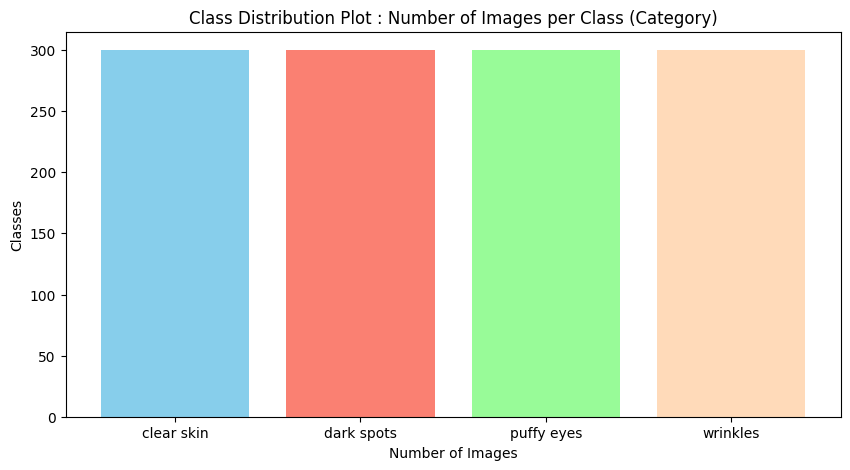

In [68]:
def plot_class_distribution(labels, counts):
    plt.figure(figsize=(10,5))
    plt.bar(labels, counts,color=('skyblue','salmon','palegreen','peachpuff'))
    plt.title('Class Distribution Plot : Number of Images per Class (Category)')
    plt.xlabel('Number of Images')
    plt.ylabel('Classes')
    plt.savefig('Class_Distribution_Plot.png')
    plt.show()
plot_class_distribution(labels, counts)

In [69]:
#This function plots the augmentation scattering per batch

def plot_augmentation_scattering(generator, title="Augmentation Scattering Per Batch"):

    images, labels = next(generator)

    class_indices = np.argmax(labels, axis=1) #to get the class indices from one-hot encoded labels

    # count how many images per class appear in the batch
    unique_classes, counts = np.unique(class_indices, return_counts=True)

    # class names
    class_labels = list(generator.class_indices.keys())

    # Plot
    plt.figure(figsize=(8, 5))
    plt.bar(class_labels, counts)
    plt.xlabel("Classes")
    plt.ylabel("Images in this batch")
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.show()

    return unique_classes, counts

In [71]:
#In this cell a generator object is created for training and validation data augmentation. The rules for augmentation are defined within the ImageDataGenerator function.

train_datagen = ImageDataGenerator(
    rescale=1./255,          
    rotation_range=20,       
    width_shift_range=0.15,   
    height_shift_range=0.15,  
    zoom_range=0.2,          
    horizontal_flip=True,    
    fill_mode='nearest',     
    validation_split=0.2,
    brightness_range=[0.8,1.2]     
)

valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [72]:
#In this cell, the augmentation generator is applied to actual image data from the dataset directory. The images are resized to 224x224 pixels, and the batch size is set to 32. Training and validation subsets are created based on the defined split.(80-20)

img_size = (224, 224)
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    dataset,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  #One-hot encoding
    shuffle=True,
    subset='training'
)

valid_generator = valid_datagen.flow_from_directory(
    dataset,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)



Found 960 images belonging to 4 classes.
Found 240 images belonging to 4 classes.


One-hot encoded labels:
 [[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


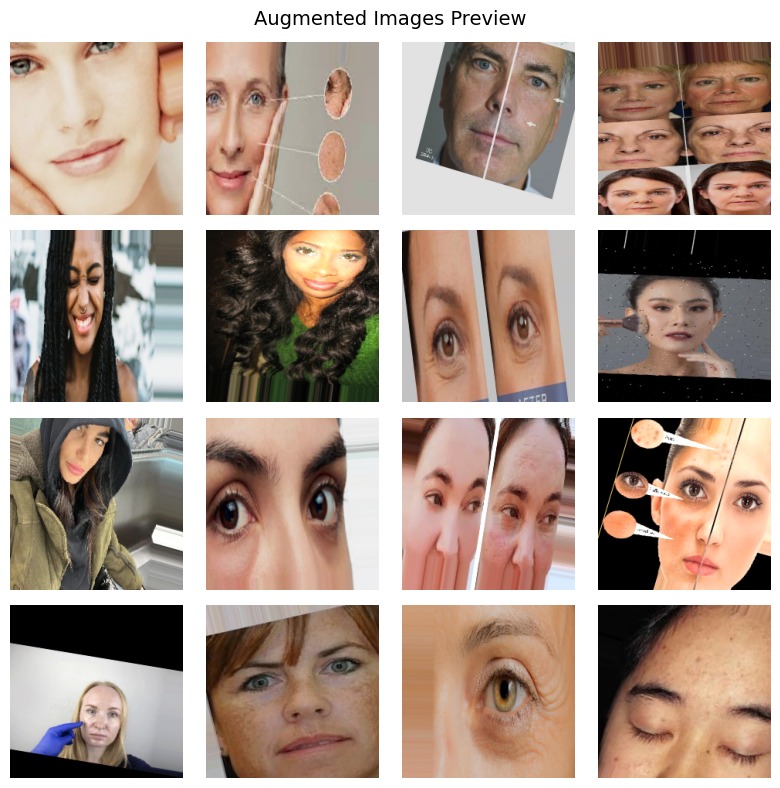

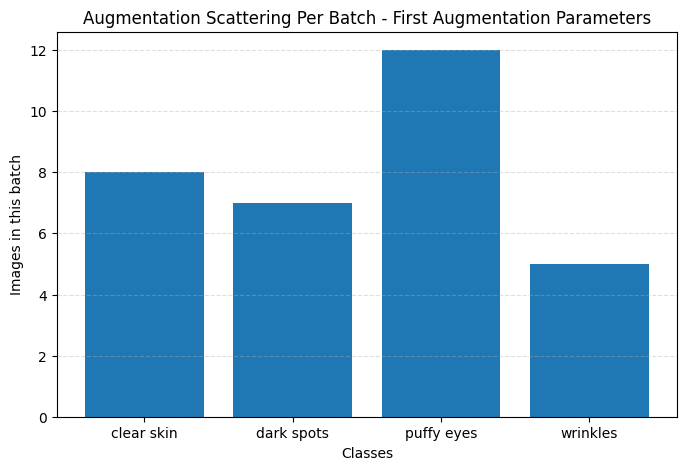

(array([0, 1, 2, 3], dtype=int64), array([ 8,  7, 12,  5], dtype=int64))

In [73]:
#See augmented images using the First augmentation parameters
# Take one batch from train generator
images, labels = next(train_generator)
print("One-hot encoded labels:\n", labels)


plt.figure(figsize=(8, 8))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i])
    plt.axis('off')

plt.suptitle("Augmented Images Preview", fontsize=14)
plt.tight_layout()

# Save the figure
count = len(os.listdir('Outputs'))
filename = f'Outputs/Augmented_Images_{count+1}.png'
plt.savefig(filename)

plt.show()

plot_augmentation_scattering(train_generator, title="Augmentation Scattering Per Batch - First Augmentation Parameters")

In [88]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

def build_model(base_model, num_classes, lr=1e-4, dropout_rate=0.5):

    # Freeze base model
    base_model.trainable = False

    # Custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [89]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping

# Load pretrained MobileNetV2
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Build model
model = build_model(
    base_model=base_model,
    num_classes=train_generator.num_classes,
    lr=1e-4,
    dropout_rate=0.5
)

# Callbacks for Phase 1
callbacks_phase1 = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=6,
        restore_best_weights=True
    )
]

# Train (Feature Extraction)
history_phase1 = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=15,
    callbacks=callbacks_phase1
)


Epoch 1/15
30/30 [==============================] - 33s 973ms/step - loss: 1.9330 - accuracy: 0.2604 - val_loss: 1.4189 - val_accuracy: 0.3333
Epoch 2/15
30/30 [==============================] - 23s 748ms/step - loss: 1.7193 - accuracy: 0.3125 - val_loss: 1.2525 - val_accuracy: 0.4125
Epoch 3/15
30/30 [==============================] - 20s 672ms/step - loss: 1.5853 - accuracy: 0.3542 - val_loss: 1.1353 - val_accuracy: 0.4833
Epoch 4/15
30/30 [==============================] - 19s 610ms/step - loss: 1.4562 - accuracy: 0.3896 - val_loss: 1.0431 - val_accuracy: 0.5458
Epoch 5/15
30/30 [==============================] - 19s 642ms/step - loss: 1.3210 - accuracy: 0.4500 - val_loss: 0.9571 - val_accuracy: 0.6042
Epoch 6/15
30/30 [==============================] - 26s 883ms/step - loss: 1.2720 - accuracy: 0.4615 - val_loss: 0.8926 - val_accuracy: 0.6542
Epoch 7/15
30/30 [==============================] - 16s 522ms/step - loss: 1.1856 - accuracy: 0.4938 - val_loss: 0.8416 - val_accuracy: 0.6917

In [90]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Unfreeze top layers for fine-tuning
base_model.trainable = True

for layer in base_model.layers[:-50]:
    layer.trainable = False


model.compile(
    optimizer=Adam(learning_rate=5e-6),  # VERY IMPORTANT
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_finetune = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=2,
        min_lr=1e-6
    )
]

history_finetune = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=8,
    callbacks=callbacks_finetune
)

model.save("MobileNetV2_finetuned.h5")



Epoch 1/8
30/30 [==============================] - 23s 601ms/step - loss: 1.2963 - accuracy: 0.4479 - val_loss: 0.5910 - val_accuracy: 0.8125 - lr: 5.0000e-06
Epoch 2/8
30/30 [==============================] - 16s 546ms/step - loss: 1.1804 - accuracy: 0.4885 - val_loss: 0.5700 - val_accuracy: 0.8250 - lr: 5.0000e-06
Epoch 3/8
30/30 [==============================] - 17s 558ms/step - loss: 1.0870 - accuracy: 0.5406 - val_loss: 0.5512 - val_accuracy: 0.8292 - lr: 5.0000e-06
Epoch 4/8
30/30 [==============================] - 17s 581ms/step - loss: 1.0003 - accuracy: 0.5760 - val_loss: 0.5304 - val_accuracy: 0.8333 - lr: 5.0000e-06
Epoch 5/8
30/30 [==============================] - 17s 575ms/step - loss: 0.9200 - accuracy: 0.6406 - val_loss: 0.5154 - val_accuracy: 0.8208 - lr: 5.0000e-06
Epoch 6/8
30/30 [==============================] - 18s 592ms/step - loss: 0.8729 - accuracy: 0.6479 - val_loss: 0.4997 - val_accuracy: 0.8250 - lr: 5.0000e-06
Epoch 7/8
30/30 [=============================

In [93]:
best_val_acc = max(history_finetune.history['val_accuracy'])
best_epoch = history_finetune.history['val_accuracy'].index(best_val_acc) + 1
best_train_acc = max(history_finetune.history['accuracy'])
train_acc_at_best_epoch = history_finetune.history['accuracy'][best_epoch]

print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Best Epoch: {best_epoch}")
print(f"Best Training Accuracy: {best_train_acc:.4f}")
print(f"Training Accuracy at Best Epoch: {train_acc_at_best_epoch:.4f}")



Best Validation Accuracy: 0.8333
Best Epoch: 4
Best Training Accuracy: 0.7021
Training Accuracy at Best Epoch: 0.6406


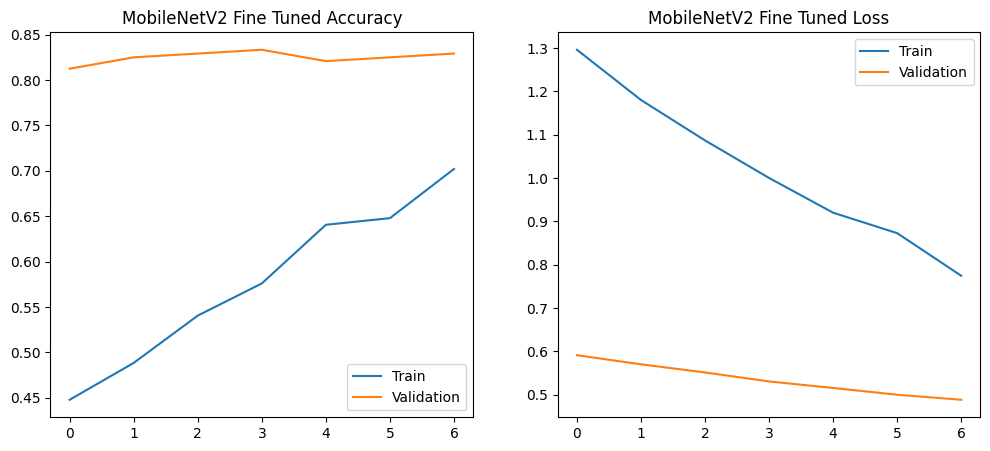

MobileNetV2: 0.8333333134651184
MobileNetV2: 0.7020833492279053


In [95]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{model_name} Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{model_name} Loss')
    plt.legend()

    plt.show()

plot_history(history_finetune, "MobileNetV2 Fine Tuned")

print("MobileNetV2:", max(history_finetune.history['val_accuracy']))
print('MobileNetV2:', max(history_finetune.history['accuracy']))


